In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne

from invert.forward import get_info, create_forward_model
from invert.util import pos_from_forward
from invert.evaluate import eval_auc

pp = dict(surface='white', hemi='both', verbose=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')
pos = pos_from_forward(fwd)
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    9.4s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


# Simulate

In [10]:
from invert.solvers.esinet import generator

sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1,
    n_sources=10,
    n_orders=(0, 3),
    snr_range=(1e99, 2e99),
    n_timecourses=200,
    n_timepoints=200,
    scale_data=False, 
    add_forward_error=False,
    forward_error=0.3)

gen = generator(fwd, **sim_params)

No projector specified for this dataset. Please consider the method self.add_proj.


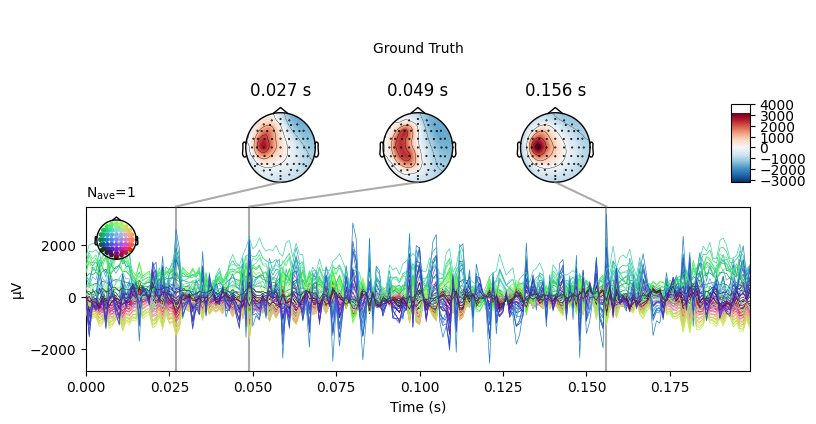

In [17]:
x, y = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

# Solve

In [24]:
from invert import Solver
solver_lstm = Solver("CovCNN")
solver_lstm.make_inverse_operator(fwd, evoked,  n_sources=10, n_orders=(0, 2))
# solver_lstm.epsilon=0.9
# stc_ = solver_lstm.apply_inverse_operator(evoked)

# # stc_.data /= abs(stc_.data).max()
# brain = stc_.plot(**pp)
# brain.add_text(0.1, 0.9, solver_lstm.name, 'title',
#                font_size=14)

# evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
# evoked_.plot_joint()

# print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
# print("L1 = ",  np.linalg.norm(stc_.data, ord=1))
# print("auc: ", eval_auc(stc.data[:, 0], stc_.data[:, 0], pos))

Create Generator:..
Build Model:..
Train Model:..
Epoch 1/300
10/10 [==============================] - 1s 71ms/step - loss: -0.5609 - cosine_similarity: 0.0536 - val_loss: -1.4311 - val_cosine_similarity: 0.0528
Epoch 2/300
10/10 [==============================] - 2s 45ms/step - loss: -1.6830 - cosine_similarity: 0.0527 - val_loss: -1.8027 - val_cosine_similarity: 0.0528
Epoch 3/300
10/10 [==============================] - 2s 45ms/step - loss: -1.8142 - cosine_similarity: 0.0529 - val_loss: -1.8249 - val_cosine_similarity: 0.0528
Epoch 4/300
10/10 [==============================] - 2s 54ms/step - loss: -1.7654 - cosine_similarity: 0.0519 - val_loss: -1.8286 - val_cosine_similarity: 0.0528
Epoch 5/300
10/10 [==============================] - 2s 54ms/step - loss: -1.8104 - cosine_similarity: 0.0525 - val_loss: -1.8297 - val_cosine_similarity: 0.0528
Epoch 6/300
10/10 [==============================] - 2s 40ms/step - loss: -1.8194 - cosine_similarity: 0.0526 - val_loss: -1.8302 - val_cosi

In [19]:
y = evoked.data
C = y@y.T
C = C[np.newaxis, :, :, np.newaxis]

# Get prior source covariance from model
gammas = solver_lstm.model.predict(C, verbose=0)[0]
plt.figure()
plt.plot(gammas)